# Analysis of Korean Corona Cases

KCDC (Korea Centers for Disease Control & Prevention) announces the information of COVID-19 quickly and transparently.
It provides a structured dataset based on the report materials of KCDC and local governments. This datset is available on kaggle and consists of 14 features discribing 5,165 patients infected with the Corona Virus in 2020. 
In order to define the data related questions, we will look at the data and choose features we want to conduct our analysis on.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Dataset 
df = pd.read_csv('PatientInfo.csv')
df_init = df

In [3]:
df.head(5)

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2.002000e+09,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1.000000e+09,2,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          5165 non-null   object 
 1   sex                 4042 non-null   object 
 2   age                 3784 non-null   object 
 3   country             5164 non-null   object 
 4   province            5164 non-null   object 
 5   city                5070 non-null   object 
 6   infection_case      4245 non-null   object 
 7   infected_by         1345 non-null   float64
 8   contact_number      791 non-null    object 
 9   symptom_onset_date  690 non-null    object 
 10  confirmed_date      5161 non-null   object 
 11  released_date       1587 non-null   object 
 12  deceased_date       66 non-null     object 
 13  state               5164 non-null   object 
dtypes: float64(1), object(13)
memory usage: 565.0+ KB


A first glance at the data shows that the datset provides some demographic information in combination with information about the location, the timestamp and the case of infection. Some of these features present a high percentage of null values which makes them inappropriate for the following analysis.

## 1. Business Understanding

In order to start the analysis, we have to define the questions we want to answer. As we have three columns that describe the patients' location, we decide to focus on the feature "province" to describe the location and drop the rest. Next to that, the dataset provides demographic features, which describe the sex and age of the patient. Another interesting topic to investigate is the duration of illness, since the dataset offers sufficient time related information. Before we precisely define the questions we want to answer, we have to check if the columns of the datset are suited, especially in terms of missing values.

## 2. Data Understanding

In [5]:
print(f"Fraction of NA's in column sympton_onset_date: {df['symptom_onset_date'].isna().mean()}\n\
Fraction of NA's in column confirmed_date: {df['confirmed_date'].isna().mean()}\n\
Fraction of NA's in column released_date: {df['released_date'].isna().mean()}\n\
Fraction of NA's in column deceased_date: {df['deceased_date'].isna().mean()}\n")

Fraction of NA's in column sympton_onset_date: 0.8664085188770572
Fraction of NA's in column confirmed_date: 0.0007744433688286545
Fraction of NA's in column released_date: 0.6927395934172313
Fraction of NA's in column deceased_date: 0.9872216844143272



Here we can see that the provided time features show a lot of missing values. To further investigate the duration of the infection, we have to decide on two columns we want to build this feature with. Since symptom_onset_date and deceased_date have the highest portion of null values, we will drop these features and engineer the feature "duration" with help of the remaining two columns in the upcoming section. As we have already seen in the initial data exploration, sex and age also include some missing values, which we will care about in the next section as well. 
After the first two steps we define the following 3 questions, we will take a closer look at in the further analysis:

#### a) Which province had the most Corona cases?
#### b) Is there any difference in duration of illness for male vs female citizen? 
#### d) Which features have the biggest influence on the duration of the infection? 

## 3. Data Preparation

Befor we can start our analysis and model the data, we have to prepare it. We will do this with help of the function prepare_df. This function includes dropping null values for the two columns confirmed_date and released_date. After that, we transform these columns to datetime objects, in order to engineer the duration feature. In a next step, we use the function time_to_integer, to extract the days from the datetime object and safe it as an integer. As a last step we drop the columns we will not use in the upcoming analysis.

In [6]:
def time_to_integer(time):
    """Extracts days from datetime object
    :param time:
        datetime object
    :return:
        days of datetime object
    """
    time = str(time)
    t, _, _ = time.split(" ")
    return int(t)


def prepare_df(df):
    """Function to drop prepare the initial dataframe. This includes dropping NA's in confirmed_data, released_date
    and afterwards transforming these columns to datetime objects. After that a new feature "duration" is created and
    unnecessary columns are being dropped
    :param df:
        dataframe to be prepared
    :return:
        prepared dataframe
    """
    df = df.dropna(subset=["confirmed_date", "released_date"])
    assert df.confirmed_date.isna().sum != 0 or df.released_date != 0
    df[["confirmed_date", "released_date"]] = df[
        ["confirmed_date", "released_date"]
    ].apply(pd.to_datetime)
    df["duration"] = df["released_date"] - df["confirmed_date"]
    df["duration"] = df["duration"].apply(time_to_integer)
    df = df.drop(
        [
            "symptom_onset_date",
            "deceased_date",
            "patient_id",
            "country",
            "infected_by",
            "state",
            "contact_number",
            "confirmed_date",
            "released_date",
            "city",
            "infection_case"
        ],
        axis=1,
    )

    return df

In [7]:
df = prepare_df(df);

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1587 entries, 0 to 5161
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sex       1586 non-null   object
 1   age       1576 non-null   object
 2   province  1587 non-null   object
 3   duration  1587 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 62.0+ KB


Now we can observe, that we still have some missing values in the demographic columns sex and age. As our Machine Learning algorithm, we will use to answer question c) can not handle missing values, we will fill them with the mode of the respective column.

In [9]:
fillna = lambda col: col.fillna(col.mode()[0])
df = df.apply(fillna)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1587 entries, 0 to 5161
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sex       1587 non-null   object
 1   age       1587 non-null   object
 2   province  1587 non-null   object
 3   duration  1587 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 62.0+ KB


This final dataframe consists only of the features that we need to answer our questions and does not contain any null values.

## 4. Data Modeling and Evaluation

### a) Which province had the most Corona cases?

In order not to distort the statistics we will use the initial dataframe to answer this question. Initial dataframe means that we retain the instances we dropped in the prepare_df column. These instances were the ones, we had a null value in either the confirmed_date or the released_date. If we would use the prepared dataframe to answer this question, we would distort the initial cases' counts in the different provinces. 
In the plot, we can see that Seoul had the most cases, followed by Gyeongsangbuk-do and Gyeonggi-do. The rest of the cases are distributed across another 14 provinces.

In [1]:
plt.figure(figsize = (20,3))
sns.countplot(x = "province", data = df_init, order=df_init.province.value_counts().iloc[:20].index)
plt.title("Count of Corona infections across the 17 provinces of Korea")
plt.xticks(rotation=45);

NameError: name 'plt' is not defined

The second barplot shows the distribution of infections across provinces after preparing the dataframe as described below. Here we can see a completely different distribution. Comparing these two barplots, we suppose that the provinces Seoul and Gyeonggi-do tracked the dates of infection (confirmed_date and released_date) very poorly. In contrast, Incheon tracked a high portion of its Corona infections' dates.

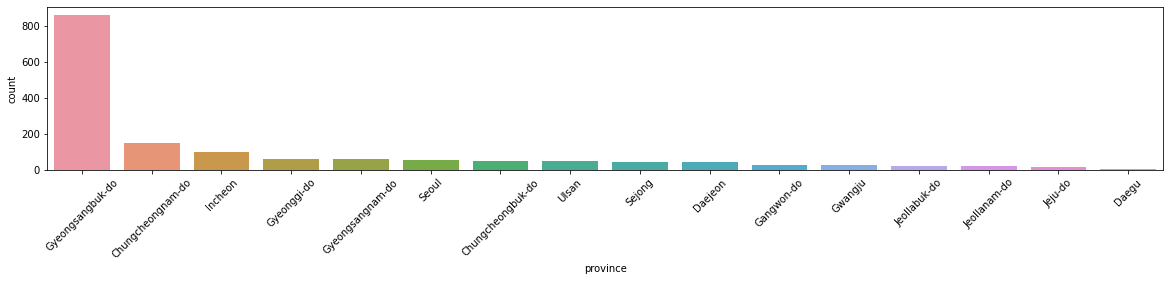

In [101]:
plt.figure(figsize = (20,3))
sns.countplot(x = "province", data = df, order=df.province.value_counts().iloc[:20].index)
plt.xticks(rotation=45);

### b) Is there any difference in duration of illness for male vs female patients? 

The next question we want to investigate is, if there is a difference in duration for male vs female citizen. To solve this question we plot the histograms for both genders and added a density line on these. Here we can see, that there is a higher peak for females in the duration around 18 days in comparison to the males. On the other hand, the density is a bit higher in the interval of 1-15 days. 
In conclusion, there are no significant differences in duration across the gender, although we can note some differences in the density lines. 

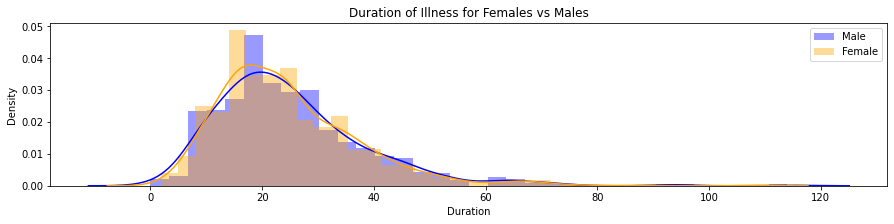

In [102]:
plt.figure(figsize = (15,3))
sns.distplot(df[df.sex == "male"].duration, label = "Male", color = "blue")
sns.distplot(df[df.sex == "female"].duration, label = "Female", color = "orange")
plt.xlabel("Duration")
plt.title("Duration of Illness for Females vs Males")
plt.legend(loc="upper right")
plt.show()

### d) Which of the patients' properties have the biggest influence on the duration of the infection? 

In order to answer this question, we will use a Linear Regression. We chose this algorithm, since its results are easy to interpret. Before we do so, we have to dummy code the categoric variables, since this algorithm is not able to deal with categoric variables. After that we split the dependend variable duration from the rest of the data and create a train and test set, in order to be able to evaluate our model's predictions with data the model has not seen yet. We merge all these steps into the function create_test_train() and apply it on the dataframe.

In [103]:
def create_test_train(df):
    """
    Creates dummy columns for categoric features and splits into test and train for X and y.
    :param df:
        dataframe with categoric columns
    :return:
        X_train and y_train to be used for Regression fit and X_test and y_Test for testing the model on unseen data
    """
    cat_vars = df.select_dtypes(include=["object"]).copy().columns
    for var in cat_vars:
        df = pd.concat(
            [
                df.drop(var, axis=1),
                pd.get_dummies(df[var], prefix=var, prefix_sep="_", drop_first=True),
            ],
            axis=1,
        )

    X = df.drop("duration", axis=1)
    y = df["duration"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

In [104]:
X_train, X_test, y_train, y_test = create_test_train(df)

In [105]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In order to answer the question, we now investigate the coefficients - our model estimated - by fitting the training data:

In [106]:
def coef_weights(coefficients, X_train):
    """
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the
    variable attached to the coefficient.
    :param coefficients
        the coefficients of the linear model
    :param X_train
        the training data, so the column names can be used
    :return:
        coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    """
    coefs_df = pd.DataFrame()
    coefs_df["est_int"] = X_train.columns
    coefs_df["coefs"] = model.coef_
    coefs_df["abs_coefs"] = np.abs(model.coef_)
    coefs_df = coefs_df.sort_values("abs_coefs", ascending=False)
    return coefs_df

In [107]:
coef_df = coef_weights(model.coef_, X_train)

coef_df.head(20)

,est_int,coefs,abs_coefs
1,age_100s,41.224556,41.224556
12,province_Daegu,-17.725436,17.725436
8,age_70s,10.058049,10.058049
9,age_80s,9.558837,9.558837
24,province_Seoul,-8.107969,8.107969
16,province_Gyeonggi-do,-7.875213,7.875213
23,province_Sejong,5.823825,5.823825
10,age_90s,4.985517,4.985517
14,province_Gangwon-do,-4.807489,4.807489
15,province_Gwangju,-4.172708,4.172708


Here we can see that the dummy coded column age_100s has the highest coefficient of our Linear Regression model. This means that this variable has the highest influence on the duration of illness. The second highest absolute coefficient is the province_Daegu column. Since its coefficient is negative, it seems to have a negative influence on the duration of illness. This could imply that the province Daegu has a good healthcare system in comparison to the other provinces.
Next to these two columns, the dummy variables age_70s and age_80s have a relative high coefficient. This is a intuitive finding, because a higher age usually implies a worse course of the corona disease. Additionally, our findings from question b) can be proved: Since the coefficient for the variable sex_male is very low, there is no big influence of the gender on the infection's duration.

Next to the interpretation of the coefficients, we can make predictions with our model: 

In [108]:
preds = model.predict(X_test)
preds[0:5]

array([23.30468045, 24.08673518, 26.43568773, 17.58459435, 24.04885556])

After that we want to evaluate these predictions on our test data. A good measurement for regression problems is the R-squared. It is defined between 0 and 1 and the higher its value, the better the models predictions.

In [109]:
r2_score(y_test, preds)

0.07998722173868267

This measurement returns a value of around 8%. This means that our model is not able to predict the durations well. This is sometimes the case when it comes to the application of Linear Regression models, because it requires a **linear** relation between the dependend and the independend variable. Another problem can be that the picked variables are not able to predict the duration well. To investigate if it is just a nonlinear relation that causes these bad results, we will try to train a Random Forest and evaluate the results analogous to the previous procedure. 

In [110]:
rf_model = RandomForestRegressor()

In [111]:
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [112]:
preds_rf = rf_model.predict(X_test)
preds_rf[0:5]

array([19.31720349, 25.0506787 , 26.14393459, 17.75380952, 25.5608575 ])

In [113]:
r2_score(y_test, preds_rf)

0.04680342869851506

In [114]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Using the model of the Random Forest by Skikit-Learn with the default hyperparameters, we obtain even worse results. We will further analyze it that is the case because of the wrong hyperparameter initialization with use of a Randomized Search including Cross Validation.

In [115]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [116]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [117]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [118]:
preds_rf_random = rf_random.predict(X_test)

In [119]:
r2_score(y_test, preds_rf_random)

0.09833053588641472

We can observe a R-squared of around 10%, which is better than the Linar Regression and the RF with the initial Hyperparameters. This shows again, how important it is, to also optimize them and not just use the default values. Although we improved our predictions, a R-squared of 10% on the test data still does not indicate a good model. 

We can conclude that the variables picked (age, sex and province) are not able to predict the duration of illness very well. This is an intuitive result, since the duration is much more complex to explain than just using these three variables. If we had more information, f.e. if the patient had any previous diseases, we could probably obtain better results.